# 1 Import libraries
The required libraries for this notebook are list below

In [1]:
# Basic libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import os
from tqdm.auto import tqdm

# Libraries for image preprocessing, data augmentation and feature extraction
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern
import imgaug.augmenters as iaa
import pywt

# Libraries for scaling and dimensionality reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Libraries for cross-validation
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

# Libraries for classifiers used
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm, metrics

# 2 Data Preprocessing

In [2]:
df_train = pd.read_csv('./dataset/label.csv')
df_train.head()

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor


## 2.1 Create function for binary labelling of classes
0 for no tumor, 1 for tumor

In [3]:
def create_binary(df):
    '''
    Inputs
        df: Label data.

    Return
        binary: List of binary labels - 0 if no tumor, 1 if tumor.
    '''

    binary = []
    for label in df['label']:
        if 'no_tumor' in label:
            binary.append(0)
        else:
            binary.append(1)
    return binary

## 2.2 Augment training images
Augment the images by rotating it, flipping it horizontally, adding gaussian blur, shearing, sharpening and blurring edges.
This was only done for images with no tumor to balance the training dataset

In [4]:
train_path = './dataset/image'
original_images = []
for filename in tqdm(df_train['file_name']):
    # obtain pixel data from the image after converting image to grayscale
    im = imread(os.path.join(train_path, filename), as_gray=True)
    original_images.append(im)

# Index of images with no_tumor label
noTumor_idx = df_train.index[df_train['label'] == 'no_tumor'].tolist()
# List of images with no_tumor label
images_noTumor = []
for idx in tqdm(noTumor_idx):
    images_noTumor.append(original_images[idx])

# Augmentation sequence 1
seq1 = iaa.Sequential([
    iaa.Fliplr(1),  # horizontal flips
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-10, 10)
    )
], random_order=True)

# Augmentation sequence 2
seq2 = iaa.Sequential([
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-10, 10)
    ),
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    )
], random_order=True)

# Augmentation sequence 3
seq3 = iaa.Sequential([
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0)),
    iaa.Affine(
        rotate=(-180, 180),
        shear=(-10, 10)
    )
], random_order=True)

# Quadruple the no_tumor images
images_aug_noTumor1 = seq1(images=images_noTumor)
images_aug_noTumor2 = seq2(images=images_noTumor)
images_aug_noTumor3 = seq3(images=images_noTumor)

# Concatenate the lists of image pixel data to form a new dataset with augmented images
images_augmented = original_images + images_aug_noTumor1 + images_aug_noTumor2 + images_aug_noTumor3

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/454 [00:00<?, ?it/s]

In [5]:
# fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 9))
# # fig.suptitle('Original vs Discrete Wavelet Transformed')
# axs[0].set_title('Original')
# axs[0].imshow(original_images[20], cmap=plt.cm.gray)
# axs[1].set_title('Augmented')
# axs[1].imshow(images_aug_noTumor1[3], cmap=plt.cm.gray)
# axs[2].set_title('Augmented (2)')
# axs[2].imshow(images_aug_noTumor2[3], cmap=plt.cm.gray)
# axs[3].set_title('Augmented (3)')
# axs[3].imshow(images_aug_noTumor3[3], cmap=plt.cm.gray)

## 2.3 Preprocess train images
Images are de-noised by using Discrete Wavelet Transform, decreasing image size from (512,512) to (256,256). To use augmented images, change augmentation value to True

In [51]:
augmentation = False

if augmentation:
    images = images_augmented
else:
    images = original_images
    
train_images = []
for image in tqdm(images):
    coeffs = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs
    train_images.append(LL)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [7]:
# img = imread('./dataset/image/IMAGE_0000.jpg', as_gray = True)
# coeffs = pywt.dwt2(img, 'haar')
# LL, (LH, HL, HH) = coeffs

# fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
# # fig.suptitle('Original vs Discrete Wavelet Transformed')
# axs[0].set_title('Original')
# axs[0].imshow(img, cmap=plt.cm.gray)
# axs[1].set_title('Level 1 2D DWT')
# axs[1].imshow(LL, cmap=plt.cm.gray)

## 2.4 Preprocess test images

In [8]:
df_test = pd.read_csv('./test/label.csv')
test_path = './test/image'

test_images = []
for filename in tqdm(df_test['file_name']):
    im = imread(os.path.join(test_path, filename), as_gray=True)
    coeffs = pywt.dwt2(im, 'haar')
    LL, (LH, HL, HH) = coeffs
    test_images.append(LL)

  0%|          | 0/200 [00:00<?, ?it/s]

# 3 Feature Extraction

## 3.1 Histogram of Orientated Gradients (HOG)
Function to extract HOG information from images

In [9]:
def extract_hog(images_pixelData):
    '''
    Inputs
        images_pixelData: Dataset of image pixel data.
        
    Return
       hog_features: A list of HOG features for each image
    '''
    hog_features = []
    for i in tqdm(range(len(images_pixelData))):
        resized_im = resize(images_pixelData[i], (128, 64))
        # Extract Histogram of Oriented Gradients (HOG) for the image
        fd = hog(resized_im, orientations = 9, pixels_per_cell = (8, 8),
                            cells_per_block = (2, 2), visualize = False, block_norm='L2-Hys')
        hog_features.append(fd)

    return hog_features

## 3.2 Local Binary Pattern (LBP)
Function to extract LBP information from images

In [10]:
def extract_lbp(images_pixelData, numPoints, radius):
    '''
    Inputs
        images_pixelData: Dataset of image pixel data,
        numPoints: Number of circularly symmetric neighbour set points,
        radius: Radius of circle (spatial resolution of the operator).
        
    Return
       lbp_features: A list of Local Binary Pattern (LBP) features for each image
    '''

    lbp_features = []
    for i in tqdm(range(len(images_pixelData))):
        # Extract Local Binary Pattern (LBP) for the image
        lbp = local_binary_pattern(images_pixelData[i], numPoints, radius, method="uniform")
        # Create bins for histogram
        n_bins = int(lbp.max() + 1)
        # Create histogram for image
        (hist, _) = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        
        # # normalize the histogram
        # hist = hist.astype("float")
        # hist /= (hist.sum() + eps)
        
        lbp_features.append(hist)
    return lbp_features

## 3.3 Multi-Level DWT
Function to transform images multiple times with DWT

In [11]:
def extract_multidwt(images_pixelData, levels):
    '''
    Inputs
        images_pixelData: Dataset of image pixel data,
        levels: Levels of multi-DWT to use.

    Return
       multidwt: A list of Multi-level DWT features for each image
    '''
    multidwt = []
    for i in tqdm(range(len(images_pixelData))):
        LL = images_pixelData[i]
        for j in range(levels):
            coeffs = pywt.dwt2(LL, 'haar')
            LL, (LH, HL, HH) = coeffs

        multidwt.append(LL.ravel())

    return multidwt

In [12]:
# img = imread('./dataset/image/IMAGE_0000.jpg', as_gray = True)
# coeffs = pywt.dwt2(img, 'haar')
# LL, (LH, HL, HH) = coeffs

# fd, hog_img = hog(resize(LL, (128, 64)), orientations=9, pixels_per_cell=(8, 8),
#                   cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')

# coeffs2 = pywt.dwt2(LL, 'haar')
# LL2, (LH2, HL2, HH2) = coeffs2
# coeffs3 = pywt.dwt2(LL2, 'haar')
# LL3, (LH3, HL3, HH3) = coeffs3

# lbp = local_binary_pattern(LL, 8, 1, method="uniform")

# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 9))
# # fig.suptitle('Texture Features Used')
# axs[0].set_title('HOG Features')
# axs[0].imshow(hog_img, cmap=plt.cm.gray)

# axs[1].set_title('Level 3 DWT')
# axs[1].imshow(LL3, cmap=plt.cm.gray)

# axs[2].set_title('LBP')
# axs[2].imshow(lbp, cmap=plt.cm.gray)

# 4 Training and Testing Model

## 4.1 Creating Train and Test set
The feature to use (HOG, LBP or Multi-DWT) can be selected by changing the value of feature

In [55]:
feature = 'hogdwt'

# Doing classification with image HOG features
if feature == 'hog':
    train_taskA = pd.DataFrame(data=extract_hog(train_images))

    if augmentation:
        train_taskA['binary_label'] = create_binary(
            df_train) + [0]*len(noTumor_idx)*3
    else:
        train_taskA['binary_label'] = create_binary(df_train)

    test_taskA = pd.DataFrame(data=extract_hog(test_images))
    test_taskA['binary_label'] = create_binary(df_test)

# Doing classification with image LBP features
elif feature == 'lbp':
    #     train_taskA = pd.read_pickle("./dataset/train_taskA_lbp.pkl")
    train_taskA = pd.DataFrame(data=extract_lbp(train_images, 8, 1))

    if augmentation:
        train_taskA['binary_label'] = create_binary(
            df_train) + [0]*len(noTumor_idx)*3
    else:
        train_taskA['binary_label'] = create_binary(df_train)

    test_taskA = pd.DataFrame(data=extract_lbp(test_images, 8, 1))
    test_taskA['binary_label'] = create_binary(df_test)

# Doing classification with Multi-DWT image data
elif feature == 'multidwt':
    #     train_taskA = pd.read_pickle("./dataset/train_taskA_multidwt.pkl")
    train_taskA = pd.DataFrame(data=extract_multidwt(train_images, 2))

    if augmentation:
        train_taskA['binary_label'] = create_binary(
            df_train) + [0]*len(noTumor_idx)*3
    else:
        train_taskA['binary_label'] = create_binary(df_train)

    test_taskA = pd.DataFrame(data=extract_multidwt(test_images, 2))
    test_taskA['binary_label'] = create_binary(df_test)

# Doing classification with HOG and LBP
elif feature == 'hoglbp':
    train_hog = pd.DataFrame(data=extract_hog(train_images))
    train_lbp = pd.DataFrame(data=extract_lbp(train_images, 8, 1))
    train_taskA = pd.concat(
        [train_hog, train_lbp], axis=1)

    if augmentation:
        train_taskA['binary_label'] = create_binary(
            df_train) + [0]*len(noTumor_idx)*3
    else:
        train_taskA['binary_label'] = create_binary(df_train)

    test_hog = pd.DataFrame(data=extract_hog(test_images))
    test_lbp = pd.DataFrame(data=extract_lbp(test_images, 8, 1))
    test_taskA = pd.concat(
        [test_hog, test_lbp], axis=1)
    test_taskA['binary_label'] = create_binary(df_test)

# Doing classification with HOG and DWT
elif feature == 'hogdwt':
    train_hog = pd.DataFrame(data=extract_hog(train_images))
    train_dwt = pd.DataFrame(data=extract_multidwt(train_images, 2))
    train_taskA = pd.concat(
        [train_hog, train_dwt], axis=1)

    if augmentation:
        train_taskA['binary_label'] = create_binary(
            df_train) + [0]*len(noTumor_idx)*3
    else:
        train_taskA['binary_label'] = create_binary(df_train)

    test_hog = pd.DataFrame(data=extract_hog(test_images))
    test_dwt = pd.DataFrame(data=extract_multidwt(test_images, 2))
    test_taskA = pd.concat(
        [test_hog, test_dwt], axis=1)
    test_taskA['binary_label'] = create_binary(df_test)

# Doing classification with LBP and DWT
elif feature == 'lbpdwt':
    train_lbp = pd.DataFrame(data=extract_lbp(train_images, 8, 1))
    train_dwt = pd.DataFrame(data=extract_multidwt(train_images, 2))
    train_taskA = pd.concat(
        [train_lbp, train_dwt], axis=1)

    if augmentation:
        train_taskA['binary_label'] = create_binary(
            df_train) + [0]*len(noTumor_idx)*3
    else:
        train_taskA['binary_label'] = create_binary(df_train)

    test_lbp = pd.DataFrame(data=extract_lbp(test_images, 8, 1))
    test_dwt = pd.DataFrame(data=extract_multidwt(test_images, 2))
    test_taskA = pd.concat(
        [test_lbp, test_dwt], axis=1)
    test_taskA['binary_label'] = create_binary(df_test)

# Doing classification with all features
elif feature == 'all':
    train_hog = pd.DataFrame(data=extract_hog(train_images))
    train_lbp = pd.DataFrame(data=extract_lbp(train_images, 8, 1))
    train_dwt = pd.DataFrame(data=extract_multidwt(train_images, 2))
    train_taskA = pd.concat(
        [train_hog, train_lbp, train_dwt], axis=1)

    if augmentation:
        train_taskA['binary_label'] = create_binary(
            df_train) + [0]*len(noTumor_idx)*3
    else:
        train_taskA['binary_label'] = create_binary(df_train)

    test_hog = pd.DataFrame(data=extract_hog(test_images))
    test_lbp = pd.DataFrame(data=extract_lbp(test_images, 8, 1))
    test_dwt = pd.DataFrame(data=extract_multidwt(test_images, 2))
    test_taskA = pd.concat(
        [test_hog, test_lbp, test_dwt], axis=1)
    test_taskA['binary_label'] = create_binary(df_test)


X_train = train_taskA.drop('binary_label', axis=1)  # All other features
y_train = train_taskA['binary_label']  # binary label

X_test = test_taskA.drop('binary_label', axis=1)  # All other features
y_test = test_taskA['binary_label']  # binary label

# X_train, X_test, y_train, y_test = train_test_split(
#     X, Y, test_size=0.3, random_state=3, shuffle=True, stratify=Y)

# print('train set: {}  | test set: {}'.format(round(((len(y_train)*1.0)/len(X)), 3),
#                                              round((len(y_test)*1.0)/len(X), 3)))

# the built-in function to standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

# fit scaler to training dataset
scaler.fit(X_train)
# transform training and test dataset with fitted scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(f'{X_train.shape[1]} features before PCA')
# Sanity check
print(('Train set mean = {mean:.2f}, Train set var = {var:.2f}').format(
    mean=X_train.mean(), var=X_train.var()))

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

7876 features before PCA
Train set mean = 0.00, Train set var = 1.00


In [56]:
pd.Series(y_train).value_counts()

1    2546
0     454
Name: binary_label, dtype: int64

## 4.2 SVM Classifier
Train and validate an SVM classifier. Halving GridSearchCV module from scikit-learn is used for cross-validating to find the best parameters for the classifier. Parameters tested are the number of features left after PCA, the SVM kernel, the SVM gamma value, the SVM C value and the SVM polynomial degree.

The best parameters for the model was then used to predict the labels of the test set. The resulting classification report and confusion matrix is shown to describe the model's performance.

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 46
max_resources_: 3000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 72
n_resources: 46
Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.972, test=0.778) total time=   0.0s
[CV 2/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 3/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.972, test=1.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.556) total time=   0.0s
[CV 1/5] END pca__n_components=0.96, svc__C=1, svc__gamma=auto, svc__k

[CV 3/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=1, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.556) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=10, svc__gamma=sc

[CV 4/5] END pca__n_components=0.96, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.556) total time=   0.0s
[CV 1/5] END pca__n_components=0.96, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.944, test=0.778) total time=   0.0s
[CV 2/5] END pca__n_components=0.96, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.972, test=0.889) total time=   0.0s
[CV 3/5] END pca__n_components=0.96, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.972, test=1.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.944, test=0.778) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, sco

[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.556) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.944, test=0.778) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.972, test=0.889) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.972, test=1.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.944, test=0.778) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, sco

[CV 2/5] END pca__n_components=0.98, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.556) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.944, test=0.778) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.972, test=0.889) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score

[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=0.944, test=0.556) total time=   0.0s
[CV 1/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.778) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.556) total time=   0.0s
[CV 1/5] END pca__n_components=0.99, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=

[CV 1/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.778) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.944) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 4/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.99, svc__C=1, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END pca__n_components=0.99, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=(train=0.973, test=0.722) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=1, svc__degree=3, svc__gamma=scale, svc__kernel=poly;, score=

[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.833) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.778) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.944) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 4/5] END pca__n_components=0.97, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.97, svc__C=100, svc__degree=2, svc__gamma=auto, svc__kernel=poly;, score=(train=1.000, test

[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.944) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.944) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.833) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.944) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc

[CV 3/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=0.973, test=0.889) total time=   0.0s
[CV 4/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 5/5] END pca__n_components=0.96, svc__C=1, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.667) total time=   0.0s
----------
iter: 2
n_candidates: 18
n_resources: 184
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END pca__n_components=0.99, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END pca__n_components=0.99, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.889) total time=   0.0s
[CV 3/5] END pca__n_components=0.99, svc__C=100, svc__degree=2, svc__gamma=scale, svc__kernel=poly;, score=(train=1.000, test=0.833) total time=   0.0s
[CV 4/5] END pca__n_componen

[CV 1/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.861) total time=   0.0s
[CV 3/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 4/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.861) total time=   0.0s
[CV 5/5] END pca__n_components=0.98, svc__C=100, svc__gamma=auto, svc__kernel=rbf;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.806) total time=   0.0s
[CV 2/5] END pca__n_components=0.97, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.861) total time=   0.0s
[CV 3/5] END pca__n_components=0.97, svc__C=100, svc_

[CV 4/5] END pca__n_components=0.96, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.904) total time=   0.1s
[CV 5/5] END pca__n_components=0.96, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.822) total time=   0.1s
[CV 1/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.932) total time=   0.1s
[CV 2/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.918) total time=   0.1s
[CV 3/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.932) total time=   0.1s
[CV 4/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.904) total time=   0.1s
[CV 5/5] END pca__n_components=0.98, svc__C=10, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.836) total time=   0.1s
[CV 1/5] END pca__n_components=0.99, svc__C=10, svc__ga

[CV 3/5] END pca__n_components=0.99, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.949) total time=   5.0s
[CV 4/5] END pca__n_components=0.99, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.929) total time=   5.2s
[CV 5/5] END pca__n_components=0.99, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.929) total time=   5.1s
----------
iter: 6
n_candidates: 2
n_resources: 2944
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END pca__n_components=0.99, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.968) total time=  22.2s
[CV 2/5] END pca__n_components=0.99, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.969) total time=  22.2s
[CV 3/5] END pca__n_components=0.99, svc__C=100, svc__gamma=scale, svc__kernel=rbf;, score=(train=1.000, test=0.968) total time=  22.3s
[CV 4/5] END pca__n_components=0.99, svc__C=100, svc__gamma=scale, svc_

,params,mean_train_score,mean_test_score,rank_test_score
144,"{'pca__n_components': 0.97, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",1.0,0.965306,1
143,"{'pca__n_components': 0.99, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",1.0,0.964966,2
140,"{'pca__n_components': 0.97, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",1.0,0.946259,3
141,"{'pca__n_components': 0.99, 'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",1.0,0.945578,4
142,"{'pca__n_components': 0.99, 'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",1.0,0.945578,4
...,...,...,...,...
118,"{'pca__n_components': 0.99, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.0,0.788889,138
117,"{'pca__n_components': 0.97, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.0,0.788889,138
111,"{'pca__n_components': 0.98, 'svc__C': 10, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.0,0.788889,138
114,"{'pca__n_components': 0.96, 'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",1.0,0.788889,138


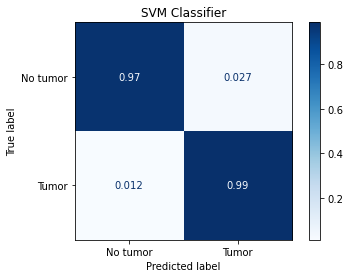

In [57]:
def SVMClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset.

    Return
        Y_pred: Predicted labels from X_test using SVM;
        results: Table of cross-validation results.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    # linear was considered in another function as kernel='linear' took very long to compute
    parameters = [
        {"svc__kernel": ["rbf"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100],
         "pca__n_components": [0.96, 0.97, 0.98, 0.99]},
        {"svc__kernel": ["poly"], "svc__gamma": ['scale', 'auto'], "svc__C": [1, 10, 100], "svc__degree": [2, 3],
         "pca__n_components": [0.96, 0.97, 0.98, 0.99]}
    ]

#     matthews = metrics.make_scorer(metrics.matthews_corrcoef)

    # Create PCA object
    pca = PCA()
    # Create SVC object
    svc = svm.SVC(probability=True)

    pca_svc = Pipeline(steps=[('pca', pca), ('svc', svc)])

    # Exhaustive search over all chosen parameters
    clf = HalvingGridSearchCV(pca_svc,
                              parameters,
                              factor=2,
                              scoring='accuracy',
                              refit=True,
                              verbose=4,
                              cv=5,
                              n_jobs=1,
                              random_state=42,
                              return_train_score=True)
    # Fit SVC model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)

    results = pd.DataFrame.from_dict(
        clf.cv_results_).sort_values(by=['rank_test_score'])
    results = results[['params', 'mean_train_score',
                       'mean_test_score', 'rank_test_score']]

    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Blues,
        normalize='true',
        ax=ax,
        display_labels=['No tumor', 'Tumor']
    )
    ax.set_title('SVM Classifier')

    return Y_pred, results


Y_pred_SVM, results_SVM = SVMClassifierCV(X_train, y_train, X_test)

print(metrics.classification_report(
    y_test, Y_pred_SVM, target_names=['No tumor', 'Tumor']))
# precision is the ability of the classifier not to label as positive a sample that is negative
# recall is the ability of the classifier to find all the positive samples
# F-beta score can be interpreted as a weighted harmonic mean of the precision and recall
# support is the number of occurrences of each class in y_test

pd.set_option('display.max_colwidth', None)
display(results_SVM)

## 4.3 KNN Classifier
Train and validate a KNN classifier. Halving GridSearchCV module from scikit-learn is used for cross-validating to find the best parameters for the classifier. Parameters tested are the number of features left after PCA and the number of neighbours to use.

The best parameters for the model was then used to predict the labels of the test set. The resulting classification report and confusion matrix is shown to describe the model's performance.

n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 68
max_resources_: 4362
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 116
n_resources: 68
Fitting 5 folds for each of 116 candidates, totalling 580 fits
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.615) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.769) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.846) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.846) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.615) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train

[CV 3/5] END neigh__n_neighbors=4, pca__n_components=0.98;, score=(train=0.926, test=0.846) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=4, pca__n_components=0.98;, score=(train=0.981, test=0.846) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=4, pca__n_components=0.98;, score=(train=0.963, test=0.923) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.870, test=0.615) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.926, test=0.769) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.926, test=0.846) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.963, test=0.846) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.944, test=0.923) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.759, test=0.538) total time=   0.0s
[

[CV 5/5] END neigh__n_neighbors=8, pca__n_components=0.98;, score=(train=0.833, test=0.769) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=8, pca__n_components=0.99;, score=(train=0.759, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=8, pca__n_components=0.99;, score=(train=0.796, test=0.692) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=8, pca__n_components=0.99;, score=(train=0.815, test=0.769) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=8, pca__n_components=0.99;, score=(train=0.778, test=0.769) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=8, pca__n_components=0.99;, score=(train=0.833, test=0.846) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=9, pca__n_components=0.96;, score=(train=0.685, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=9, pca__n_components=0.96;, score=(train=0.778, test=0.615) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=9, pca__n_components=0.96;, score=(train=0.796, test=0.692) total time=   0.0s
[

[CV 4/5] END neigh__n_neighbors=12, pca__n_components=0.98;, score=(train=0.741, test=0.692) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=12, pca__n_components=0.98;, score=(train=0.741, test=0.692) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=12, pca__n_components=0.99;, score=(train=0.704, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=12, pca__n_components=0.99;, score=(train=0.796, test=0.615) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=12, pca__n_components=0.99;, score=(train=0.796, test=0.769) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=12, pca__n_components=0.99;, score=(train=0.722, test=0.769) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=12, pca__n_components=0.99;, score=(train=0.759, test=0.769) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=13, pca__n_components=0.96;, score=(train=0.685, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=13, pca__n_components=0.96;, score=(train=0.741, test=0.615) total time=

[CV 4/5] END neigh__n_neighbors=16, pca__n_components=0.97;, score=(train=0.704, test=0.769) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=16, pca__n_components=0.97;, score=(train=0.704, test=0.692) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.685, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.759, test=0.615) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.759, test=0.692) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.722, test=0.692) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=16, pca__n_components=0.98;, score=(train=0.759, test=0.692) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=16, pca__n_components=0.99;, score=(train=0.704, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=16, pca__n_components=0.99;, score=(train=0.759, test=0.615) total time=

[CV 5/5] END neigh__n_neighbors=20, pca__n_components=0.96;, score=(train=0.704, test=0.769) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.648, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.722, test=0.615) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.704, test=0.692) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.704, test=0.615) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=20, pca__n_components=0.97;, score=(train=0.704, test=0.769) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=20, pca__n_components=0.98;, score=(train=0.667, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=20, pca__n_components=0.98;, score=(train=0.759, test=0.615) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=20, pca__n_components=0.98;, score=(train=0.722, test=0.692) total time=

[CV 1/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=0.648, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=0.722, test=0.615) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=0.704, test=0.615) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=0.630, test=0.769) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=24, pca__n_components=0.96;, score=(train=0.704, test=0.692) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.648, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.722, test=0.615) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.704, test=0.615) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=24, pca__n_components=0.97;, score=(train=0.630, test=0.769) total time=

[CV 4/5] END neigh__n_neighbors=27, pca__n_components=0.99;, score=(train=0.667, test=0.692) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=27, pca__n_components=0.99;, score=(train=0.704, test=0.615) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=28, pca__n_components=0.96;, score=(train=0.630, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=28, pca__n_components=0.96;, score=(train=0.722, test=0.615) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=28, pca__n_components=0.96;, score=(train=0.722, test=0.615) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=28, pca__n_components=0.96;, score=(train=0.685, test=0.692) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=28, pca__n_components=0.96;, score=(train=0.667, test=0.692) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=28, pca__n_components=0.97;, score=(train=0.630, test=0.538) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=28, pca__n_components=0.97;, score=(train=0.722, test=0.615) total time=

[CV 4/5] END neigh__n_neighbors=13, pca__n_components=0.97;, score=(train=0.704, test=0.815) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=13, pca__n_components=0.97;, score=(train=0.704, test=0.815) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=16, pca__n_components=0.99;, score=(train=0.731, test=0.741) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=16, pca__n_components=0.99;, score=(train=0.741, test=0.778) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=16, pca__n_components=0.99;, score=(train=0.750, test=0.852) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=16, pca__n_components=0.99;, score=(train=0.731, test=0.815) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=16, pca__n_components=0.99;, score=(train=0.769, test=0.815) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=21, pca__n_components=0.99;, score=(train=0.704, test=0.741) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=21, pca__n_components=0.99;, score=(train=0.722, test=0.778) total time=

[CV 4/5] END neigh__n_neighbors=10, pca__n_components=0.98;, score=(train=0.778, test=0.852) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=10, pca__n_components=0.98;, score=(train=0.778, test=0.815) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=14, pca__n_components=0.99;, score=(train=0.731, test=0.741) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=14, pca__n_components=0.99;, score=(train=0.759, test=0.852) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=14, pca__n_components=0.99;, score=(train=0.750, test=0.852) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=14, pca__n_components=0.99;, score=(train=0.759, test=0.815) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=14, pca__n_components=0.99;, score=(train=0.787, test=0.815) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=7, pca__n_components=0.96;, score=(train=0.787, test=0.741) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=7, pca__n_components=0.96;, score=(train=0.806, test=0.926) total time=  

[CV 5/5] END neigh__n_neighbors=10, pca__n_components=0.99;, score=(train=0.815, test=0.815) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.787, test=0.741) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.843, test=0.926) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.833, test=0.926) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.833, test=0.852) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=5, pca__n_components=0.96;, score=(train=0.898, test=0.852) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=3, pca__n_components=0.96;, score=(train=0.861, test=0.741) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=3, pca__n_components=0.96;, score=(train=0.907, test=0.889) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=3, pca__n_components=0.96;, score=(train=0.944, test=0.926) total time=   0.0s


[CV 4/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.917, test=0.852) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=4, pca__n_components=0.99;, score=(train=0.926, test=0.889) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=2, pca__n_components=0.97;, score=(train=0.972, test=0.704) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=2, pca__n_components=0.97;, score=(train=0.944, test=0.815) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=2, pca__n_components=0.97;, score=(train=0.981, test=0.852) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=2, pca__n_components=0.97;, score=(train=0.991, test=0.852) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=2, pca__n_components=0.97;, score=(train=0.972, test=0.963) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.99;, score=(train=1.000, test=0.704) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.99;, score=(train=1.000, test=0.889) total time=   0.0s
[

[CV 2/5] END neigh__n_neighbors=7, pca__n_components=0.97;, score=(train=0.839, test=0.889) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=7, pca__n_components=0.97;, score=(train=0.829, test=0.852) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=7, pca__n_components=0.97;, score=(train=0.862, test=0.815) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=7, pca__n_components=0.97;, score=(train=0.871, test=0.889) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=8, pca__n_components=0.97;, score=(train=0.880, test=0.685) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=8, pca__n_components=0.97;, score=(train=0.834, test=0.889) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=8, pca__n_components=0.97;, score=(train=0.853, test=0.870) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=8, pca__n_components=0.97;, score=(train=0.880, test=0.815) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=8, pca__n_components=0.97;, score=(train=0.889, test=0.889) total time=   0.1s
[

[CV 1/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.926, test=0.704) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.885, test=0.926) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.931, test=0.907) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.931, test=0.852) total time=   0.0s
[CV 5/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.935, test=0.944) total time=   0.0s
[CV 1/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.876, test=0.685) total time=   0.0s
[CV 2/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.857, test=0.889) total time=   0.0s
[CV 3/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.894, test=0.889) total time=   0.0s
[CV 4/5] END neigh__n_neighbors=6, pca__n_components=0.97;, score=(train=0.899, test=0.833) total time=   0.0s
[

[CV 4/5] END neigh__n_neighbors=4, pca__n_components=0.96;, score=(train=0.931, test=0.880) total time=   0.7s
[CV 5/5] END neigh__n_neighbors=4, pca__n_components=0.96;, score=(train=0.933, test=0.954) total time=   0.6s
[CV 1/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.945, test=0.889) total time=   0.7s
[CV 2/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.892, test=0.917) total time=   0.7s
[CV 3/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.931, test=0.917) total time=   0.6s
[CV 4/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.933, test=0.880) total time=   0.6s
[CV 5/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.936, test=0.954) total time=   0.7s
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.870) total time=   0.6s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.96;, score=(train=1.000, test=0.889) total time=   0.6s
[

[CV 1/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.963, test=0.851) total time=   7.8s
[CV 2/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.952, test=0.929) total time=   8.2s
[CV 3/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.950, test=0.924) total time=   7.9s
[CV 4/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.947, test=0.943) total time=   8.3s
[CV 5/5] END neigh__n_neighbors=4, pca__n_components=0.97;, score=(train=0.946, test=0.940) total time=   8.1s
[CV 1/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.885) total time=   8.4s
[CV 2/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.961) total time=   8.0s
[CV 3/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.949) total time=   8.1s
[CV 4/5] END neigh__n_neighbors=1, pca__n_components=0.97;, score=(train=1.000, test=0.972) total time=   8.2s
[

,params,mean_train_score,mean_test_score,rank_test_score
231,"{'neigh__n_neighbors': 1, 'pca__n_components': 0.96}",1.000000,0.962069,1
230,"{'neigh__n_neighbors': 1, 'pca__n_components': 0.97}",1.000000,0.962069,2
229,"{'neigh__n_neighbors': 1, 'pca__n_components': 0.96}",1.000000,0.943908,3
227,"{'neigh__n_neighbors': 1, 'pca__n_components': 0.97}",1.000000,0.943448,4
228,"{'neigh__n_neighbors': 1, 'pca__n_components': 0.98}",1.000000,0.941609,5
...,...,...,...,...
107,"{'neigh__n_neighbors': 27, 'pca__n_components': 0.99}",0.681481,0.615385,226
41,"{'neigh__n_neighbors': 11, 'pca__n_components': 0.97}",0.740741,0.615385,226
68,"{'neigh__n_neighbors': 18, 'pca__n_components': 0.96}",0.703704,0.615385,230
65,"{'neigh__n_neighbors': 17, 'pca__n_components': 0.97}",0.692593,0.615385,230


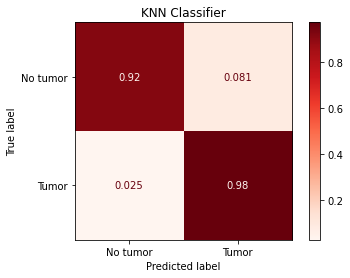

In [50]:
def KNNClassifierCV(X_train, y_train, X_test):
    '''
    Inputs
        X_train: Training dataset;
        y_train: Training labels;
        X_test: Testing dataset;

    Return
        Y_pred: Predicted labels from X_test using K-Nearest Neighbour;
        results: Table of cross-validation results.
    '''

    # Create dictionary of parameters to cross validate the estimator on
    parameters = {'neigh__n_neighbors': range(1, 30, 1),
                  "pca__n_components": [0.96, 0.97, 0.98, 0.99]}

#     matthews = metrics.make_scorer(metrics.matthews_corrcoef)

    # Create PCA object
    pca = PCA()

    # Create KNN object
    neigh = KNeighborsClassifier(algorithm='auto')

    pca_neigh = Pipeline(steps=[('pca', pca), ('neigh', neigh)])

    # Exhaustive search over all chosen parameters
    clf = HalvingGridSearchCV(pca_neigh,
                              parameters,
                              factor=2,
                              scoring='accuracy',
                              refit=True,
                              verbose=4,
                              cv=5,
                              n_jobs=1,
                              random_state=42,
                              return_train_score=True)
#     # Exhaustive search over all chosen parameters
#     clf = GridSearchCV(neigh,
#                        parameters,
#                        scoring=scoring,
#                        refit='matthews', # use matthews for refit due to imbalanced data
#                        cv=3,
#                        verbose=1,
#                        return_train_score=True)

    # Fit KNN model with the parameters for cross-validation
    clf.fit(X_train, y_train)
    # Predict labels with the best parameters from cross-validation
    print(clf.best_params_)

    results = pd.DataFrame.from_dict(
        clf.cv_results_).sort_values(by=['rank_test_score'])
    results = results[['params', 'mean_train_score',
                       'mean_test_score', 'rank_test_score']]

    # Predict labels with the best parameters from cross-validation
    Y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        Y_pred,
        cmap=plt.cm.Reds,
        normalize='true',
        ax=ax,
        display_labels=['No tumor', 'Tumor']
    )
    ax.set_title('KNN Classifier')

    return Y_pred, results


Y_pred_KNN, results_KNN = KNNClassifierCV(X_train, y_train, X_test)
print(metrics.classification_report(
    y_test, Y_pred_KNN, target_names=['No tumor', 'Tumor']))
pd.set_option('display.max_colwidth', None)
display(results_KNN)